In [157]:
import numpy as np
2from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import time
from arch import arch_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings('ignore')

stocks = 'AAPL'
start = datetime.datetime(2000, 1, 3)
end = datetime.datetime(2013, 11, 30)
s_p500 = yf.download(stocks, start=start, end = end, interval='1d')


[*********************100%%**********************]  1 of 1 completed


In [158]:
#train set과 test set 나눔
n = 500
train = s_p500[:-n]
test = s_p500[-n:]

#train
train_log_ret = np.log(train['Adj Close'])
train_ret = (train_log_ret.pct_change()[1:])

#test 
test_log_ret = np.log(test['Adj Close'])
test_ret = (test_log_ret.pct_change()[1:])

In [159]:
train_double = train_ret ** 2
train_realized_vol = train_double.rolling(5).sum()/5
train_realized_vol = np.sqrt(train_realized_vol)


test_double = test_ret ** 2
test_realized_vol = test_double.rolling(5).sum()/5
test_realized_vol = np.sqrt(test_realized_vol)

In [160]:
train_realized_vol = pd.DataFrame(train_realized_vol)
train_realized_vol.reset_index(drop=True, inplace=True)

train_returns_svm = train_ret ** 2
train_returns_svm = train_returns_svm.reset_index()
del train_returns_svm['Date']
X = pd.concat([train_realized_vol, train_returns_svm], axis=1, ignore_index=True)


In [161]:
X = X[4:].copy()
X = X.reset_index()
X.drop('index', axis=1, inplace=True)

In [162]:
test_realized_vol = pd.DataFrame(test_realized_vol)
test_realized_vol.reset_index(drop=True, inplace=True)

test_returns_svm = test_ret ** 2
test_returns_svm = test_returns_svm.reset_index()
del test_returns_svm['Date']
X_ = pd.concat([test_realized_vol, test_returns_svm], axis=1, ignore_index=True)

X_ = X_[4:].copy()
X_ = X_.reset_index()
X_.drop('index', axis=1, inplace=True)

test_realized_vol = test_realized_vol.dropna().reset_index()
test_realized_vol.drop('index', axis=1, inplace=True)

In [163]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.svm import NuSVR
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

SVR_parameters = [{"C" : [0.1,0.2], "gamma" : [0.1,0.2], "nu": [0.5]}]
# SVR_parameters = [{"C" : [0.1,0.2,0.3,1,2,3], "gamma" : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9], "nu": [0.1,0.2,0.3,0.4,0.5]}]

tscv = TimeSeriesSplit(n_splits=5)

#모델 생성
svr_rbf = NuSVR(kernel='rbf')

#RMSE 평가 지표 함수 
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred,squared=False)), greater_is_better=False)

grid_search = GridSearchCV(estimator=svr_rbf, param_grid=SVR_parameters,scoring=rmse_scorer, cv=tscv)

In [164]:
train_realized_vol = train_realized_vol.dropna().reset_index()
train_realized_vol.drop('index', axis=1, inplace=True)

,0,1
0,0.298668,0.003880
1,0.199120,0.030105
2,0.212289,0.030330
3,0.170963,0.062293
4,0.167869,0.014291
...,...,...
2990,0.009371,0.000200
2991,0.009014,0.000010
2992,0.009310,0.000097
2993,0.008479,0.000037


In [166]:
train_realized_vol[1:].values.reshape(-1,)

array([0.19911981, 0.2122888 , 0.17096298, ..., 0.00930998, 0.00847919,
       0.00833986])

In [167]:
y_rbf = grid_search.fit(X[:-1].values, train_realized_vol[1:].values.reshape(-1,))
predict_svr_lin = y_rbf.predict(X_.values) #X_ 예측

In [204]:
predict_svr_lin[:-1]

array([0.00512208, 0.00531937, 0.00721312, 0.00718988, 0.00711099,
       0.00707855, 0.00983246, 0.0088409 , 0.00887583, 0.00910092,
       0.00920101, 0.00601901, 0.0061645 , 0.00605037, 0.00639722,
       0.00626664, 0.00637163, 0.00661021, 0.00661661, 0.00575557,
       0.00563413, 0.00500752, 0.00422468, 0.00523263, 0.0057019 ,
       0.00573334, 0.00682837, 0.00757891, 0.00791159, 0.0133333 ,
       0.01328961, 0.01298654, 0.01284275, 0.01259062, 0.00569555,
       0.005628  , 0.00589428, 0.00556139, 0.00577263, 0.00671601,
       0.00919392, 0.0090015 , 0.00941518, 0.00951967, 0.00990212,
       0.00799549, 0.00799394, 0.00854724, 0.00821565, 0.00711835,
       0.00723943, 0.00733346, 0.0065281 , 0.00694442, 0.00686682,
       0.00649927, 0.0075996 , 0.00688615, 0.00642486, 0.00750892,
       0.0075733 , 0.00677927, 0.00844067, 0.01042205, 0.00986603,
       0.00981798, 0.01048186, 0.00944441, 0.00706147, 0.00701678,
       0.00708491, 0.00616269, 0.00640038, 0.00637984, 0.00671

In [203]:
test_realized_vol[1:].values

array([[0.00240629],
       [0.00464735],
       [0.00462902],
       [0.004535  ],
       [0.00449689],
       [0.00773982],
       [0.00658813],
       [0.00662907],
       [0.00689386],
       [0.00701402],
       [0.00323709],
       [0.00341091],
       [0.00327602],
       [0.00368378],
       [0.00353241],
       [0.00365544],
       [0.00393905],
       [0.00394854],
       [0.00292555],
       [0.00278144],
       [0.00203661],
       [0.00110567],
       [0.00230195],
       [0.00286013],
       [0.00289919],
       [0.00419464],
       [0.00508602],
       [0.00548102],
       [0.01184322],
       [0.01185611],
       [0.01149743],
       [0.0113252 ],
       [0.01102869],
       [0.00285446],
       [0.00277411],
       [0.00308893],
       [0.00269362],
       [0.00294427],
       [0.00406212],
       [0.00698815],
       [0.0067786 ],
       [0.00726374],
       [0.00739008],
       [0.00783783],
       [0.00558406],
       [0.00558351],
       [0.00623018],
       [0.005

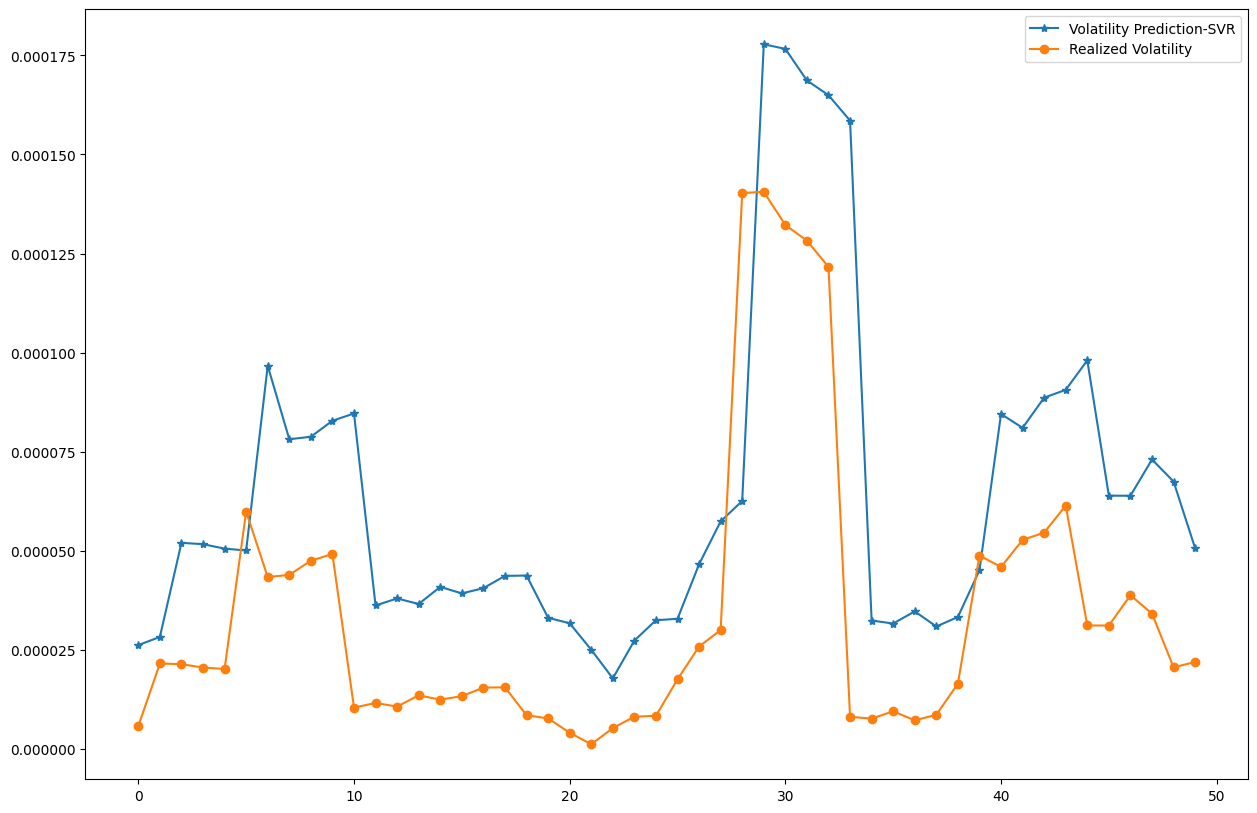

In [223]:
plt.figure(figsize=(15, 10))


plt.plot(predict_svr_lin[:50] ** 2, label='Volatility Prediction-SVR',marker='*')
plt.plot(test_realized_vol[1:51].values **2, label='Realized Volatility',marker='o')

plt.legend()


In [215]:
test_realized_vol[-30:]

,Adj Close
465,0.002391
466,0.004466
467,0.004404
468,0.004607
469,0.004945
470,0.005068
471,0.003425
472,0.005266
473,0.005634
474,0.005269


In [216]:
predict_svr_lin[-30:]

array([0.00530617, 0.00705945, 0.00700068, 0.00717218, 0.00745809,
       0.00756133, 0.00617609, 0.00773425, 0.00803973, 0.00772886,
       0.00752095, 0.00775498, 0.00620935, 0.00531096, 0.00622787,
       0.00684738, 0.0064153 , 0.00640748, 0.00638807, 0.00620919,
       0.00544944, 0.00597486, 0.00597214, 0.00622013, 0.00601247,
       0.00591102, 0.00557508, 0.00664412, 0.00771451, 0.00807659])